Run all cells below. Every new runtime will require a new installation of qiskit (annoying, but i

In [0]:
!pip install qiskit
!pip install qutip

In [0]:
#!pip uninstall pygments
#!pip install pygments

When you are prompted to upload a file, make sure to upload your token.txt (wherever you stored it) - this file should contain only the token (no punctuation, no quotes) generated on the home page of the ibm account page. This file grants you access to IBM's quantum computers, and it is imperative that you keep the file private, unless using it to upload to the python file. 

In [5]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ, QuantumCircuit, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# Loading your IBM Q account(s)
from google.colab import files
uploaded = files.upload()

with open("tokenWG.txt") as f:
    token = f.readlines()[0]
IBMQ.save_account(token)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-university', group='harvard-lukin', project='phys160')

Saving tokenWG.txt to tokenWG (2).txt


configrc.store_credentials:WARNING:2020-05-03 03:26:54,424: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2020-05-03 03:26:55,165: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
%pylab inline
from qiskit.extensions import Initialize

Populating the interactive namespace from numpy and matplotlib


## Wenjie (5/2/20)

In [0]:
# function to generate circuit that encodes a state into logical qubits
def initialize_shor9(initial_state):

  # prepare quantum circuit
  q = QuantumRegister(11)
  qc = QuantumCircuit(q)
  initialize_qubit = Initialize(initial_state)
  qc.append(initialize_qubit, [0])

  qc.cx(0, 3)
  qc.cx(0, 6)

  for i in range(0, 9, 3):
    qc.h(i)
    qc.cx(i, i+1)
    qc.cx(i, i+2)

  return qc


In [0]:
# function to add bit flip correction portion to circuit
# last 2 qubits are ancilla
# NOTE: tensor order is from n to 0 in Qiskit!!
def bitflip_shor9(initial_circuit, block, correction = True):
  '''
  initial circuit encodes state into logical qubits
  block determines which block of three to correct for (need 1, 2, or 3)
  '''
  c = ClassicalRegister(2)
  qc = initial_circuit + QuantumCircuit(c)
  i = (block-1)*3
  qc.cx(i, 9)
  qc.cx(i+1, 9)
  qc.cx(i, 10)
  qc.cx(i+2, 10)
  qc.measure([9, 10], [c[0], c[1]])

  # correction based on measured 
  if correction:
    qc.x(i+2).c_if(c, 2)
    qc.x(i+1).c_if(c, 1)
    qc.x(i).c_if(c, 3)


  return qc


In [0]:
# function to add phase flip correction portion to circuit
# last 2 qubits are ancilla
def phaseflip_shor9(initial_circuit, correction = True):
  initial_circuit.barrier()
  c = ClassicalRegister(2)
  qc = initial_circuit + QuantumCircuit(c)
  qc.h([i for i in range(9)])
  qc.cx([i for i in range(0, 6)], [9 for i in range(0, 6)])
  qc.cx([i for i in range(3, 9)], [10 for i in range(3, 9)])
  qc.h([i for i in range(9)])
  qc.measure([9, 10], [c[0], c[1]])

  # correction based on measured 
  if correction:
    qc.z(3).c_if(c, 2)
    qc.z(0).c_if(c, 1)

    qc.z(0).c_if(c, 3)
    qc.z(3).c_if(c, 3)
  return qc

In [0]:
def fidelity(desired_counts, actual_counts):
  des_tot = sum(list(desired_counts.values()))
  act_tot = sum(list(actual_counts.values()))
  fidelity = 0

  for key in desired_counts.keys():
    if actual_counts[key]:
      fidelity += sqrt(desired_counts[key]*actual_counts[key]*(1/(des_tot*act_tot)))
  return fidelity**2
    

### Testing encoding

In [113]:
# encode plus state
#initial = [1/np.sqrt(2), 1/np.sqrt(2)]
initial = [1, 0]
qc = initialize_shor9(initial)

# append measurements
c = ClassicalRegister(9)

qc = qc + QuantumCircuit(c)
qc.measure(range(9), range(9))
qc.draw()

┌─────────────────┐          ┌───┐                         ┌─┐         
 q13_0: ┤ initialize(1,0) ├──■────■──┤ H ├──■────■─────────────────┤M├─────────
        └─────────────────┘  │    │  └───┘┌─┴─┐  │     ┌─┐         └╥┘         
 q13_1: ─────────────────────┼────┼───────┤ X ├──┼─────┤M├──────────╫──────────
                             │    │       └───┘┌─┴─┐   └╥┘          ║ ┌─┐      
 q13_2: ─────────────────────┼────┼────────────┤ X ├────╫───────────╫─┤M├──────
                           ┌─┴─┐  │  ┌───┐     └───┘    ║ ┌─┐       ║ └╥┘      
 q13_3: ───────────────────┤ X ├──┼──┤ H ├──■────■──────╫─┤M├───────╫──╫───────
                           └───┘  │  └───┘┌─┴─┐  │  ┌─┐ ║ └╥┘       ║  ║       
 q13_4: ──────────────────────────┼───────┤ X ├──┼──┤M├─╫──╫────────╫──╫───────
                                  │       └───┘┌─┴─┐└╥┘ ║  ║ ┌─┐    ║  ║       
 q13_5: ──────────────────────────┼────────────┤ X ├─╫──╫──╫─┤M├────╫──╫───────
                                ┌─┴─┐┌───┐     └───┘ ║  ║  ║ └╥┘    ║  ║ ┌─┐   
 q13_6: ────────────────────────┤ X ├┤ H ├──■────■───╫──╫──╫──╫─────╫──╫─┤M├───
                                └───┘└───┘┌─┴─┐  │   ║  ║  ║  ║ ┌─┐ ║  ║ └╥┘   
 q13_7: ──────────────────────────────────┤ X ├──┼───╫──╫──╫──╫─┤M├─╫──╫──╫────
                                          └───┘┌─┴─┐ ║  ║  ║  ║ └╥┘ ║  ║  ║ ┌─┐
 q13_8: ───────────────────────────────────────┤ X ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├
                                               └───┘ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
 q13_9: ─────────────────────────────────────────────╫──╫──╫──╫──╫──╫──╫──╫──╫─
                                                     ║  ║  ║  ║  ║  ║  ║  ║  ║ 
q13_10: ─────────────────────────────────────────────╫──╫──╫──╫──╫──╫──╫──╫──╫─
                                                     ║  ║  ║  ║  ║  ║  ║  ║  ║ 
  c5_0: ═════════════════════════════════════════════╬══╬══╬══╬══╬══╩══╬══╬══╬═
                                                     ║  ║  ║  ║  ║     ║  ║  ║ 
  c5_1: ═════════════════════════════════════════════╬══╩══╬══╬══╬═════╬══╬══╬═
                                                     ║     ║  ║  ║     ║  ║  ║ 
  c5_2: ═════════════════════════════════════════════╬═════╬══╬══╬═════╩══╬══╬═
                                                     ║     ║  ║  ║        ║  ║ 
  c5_3: ═════════════════════════════════════════════╬═════╩══╬══╬════════╬══╬═
                                                     ║        ║  ║        ║  ║ 
  c5_4: ═════════════════════════════════════════════╩════════╬══╬════════╬══╬═
                                                              ║  ║        ║  ║ 
  c5_5: ══════════════════════════════════════════════════════╩══╬════════╬══╬═
                                                                 ║        ║  ║ 
  c5_6: ═════════════════════════════════════════════════════════╬════════╩══╬═
                                                                 ║           ║ 
  c5_7: ═════════════════════════════════════════════════════════╩═══════════╬═
                                                                             ║ 
  c5_8: ═════════════════════════════════════════════════════════════════════╩═

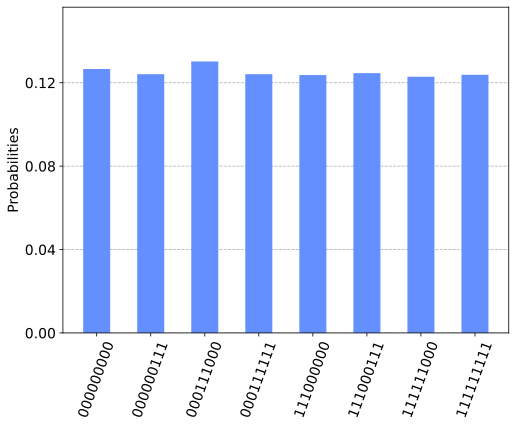

In [114]:
# test if encoding worked on simulation
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(qc, backend=backend, shots=shots)
qc_results = simulate.result()

plot_histogram(qc_results.get_counts(),figsize = (8,6),bar_labels = False)

In [115]:
# test if encoding worked on quantum computer
provider.backends()
provider.get_backend('ibmq_16_melbourne')

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-university', group='harvard-lukin', project='phys160')>

In [116]:
from qiskit.tools.monitor import job_monitor
device = provider.get_backend('ibmq_16_melbourne')
job = execute(qc, backend=device, shots=1000)
job_monitor(job)

Job Status: job has successfully run


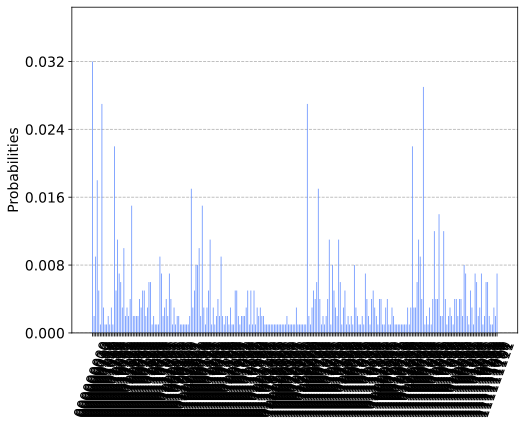

In [119]:
job_results = job.result()
plot_histogram(job_results.get_counts(),figsize = (8,6),bar_labels = False)

In [120]:
sim_counts = qc_results.get_counts()
sim_tot = sum(list(sim_counts.values()))
q_counts = job_results.get_counts()
q_tot = sum(list(q_counts.values()))

print("states we are supposed to get")
states = list(sim_counts.keys())
fidelity = 0
for key in states:
  if q_counts[key]:
      print(f"{key}: {round(q_counts[key]*(1/q_tot), 4)}")
      fidelity += np.sqrt(sim_counts[key]*q_counts[key]*(1/(q_tot*sim_tot)))

print(f"fidelity: {fidelity**2}")

states we are supposed to get
000000111: 0.027
111000111: 0.029
000000000: 0.032
111000000: 0.022
111111000: 0.006
111111111: 0.007
000111000: 0.007
000111111: 0.007
fidelity: 0.12254842458992442


Will be limiting to encode + correct on quantum hardware, seeing as encoding is already so noisy...

## Testing bit flip
Note that correction CANNOT be run on hardware! Set correction = False in bitflip_shor9

In [203]:
# encode state |0>
initial = [1, 0]
initial_circuit = initialize_shor9(initial)

# flip qubit 2
initial_circuit.x(2)

# circuit to detect for bit flip in 1st block
correction = bitflip_shor9(initial_circuit, 1)
correction.draw()

┌─────────────────┐          ┌───┐                                   »
 q38_0: ┤ initialize(1,0) ├──■────■──┤ H ├──■────■─────────■─────────■───────»
        └─────────────────┘  │    │  └───┘┌─┴─┐  │         │         │       »
 q38_1: ─────────────────────┼────┼───────┤ X ├──┼─────────┼────■────┼───────»
                             │    │       └───┘┌─┴─┐┌───┐  │    │    │       »
 q38_2: ─────────────────────┼────┼────────────┤ X ├┤ X ├──┼────┼────┼────■──»
                           ┌─┴─┐  │  ┌───┐     └───┘└───┘  │    │    │    │  »
 q38_3: ───────────────────┤ X ├──┼──┤ H ├──■────■─────────┼────┼────┼────┼──»
                           └───┘  │  └───┘┌─┴─┐  │         │    │    │    │  »
 q38_4: ──────────────────────────┼───────┤ X ├──┼─────────┼────┼────┼────┼──»
                                  │       └───┘┌─┴─┐       │    │    │    │  »
 q38_5: ──────────────────────────┼────────────┤ X ├───────┼────┼────┼────┼──»
                                ┌─┴─┐┌───┐     └───┘       │    │    │    │  »
 q38_6: ────────────────────────┤ X ├┤ H ├──■────■─────────┼────┼────┼────┼──»
                                └───┘└───┘┌─┴─┐  │         │    │    │    │  »
 q38_7: ──────────────────────────────────┤ X ├──┼─────────┼────┼────┼────┼──»
                                          └───┘┌─┴─┐       │    │    │    │  »
 q38_8: ───────────────────────────────────────┤ X ├───────┼────┼────┼────┼──»
                                               └───┘     ┌─┴─┐┌─┴─┐  │    │  »
 q38_9: ─────────────────────────────────────────────────┤ X ├┤ X ├──┼────┼──»
                                                         └───┘└───┘┌─┴─┐┌─┴─┐»
q38_10: ───────────────────────────────────────────────────────────┤ X ├┤ X ├»
                                                                   └───┘└───┘»
 c48_0: ═════════════════════════════════════════════════════════════════════»
                                                                             »
 c48_1: ═════════════════════════════════════════════════════════════════════»
                                                                             »
«                             ┌───┐ 
« q38_0: ─────────────────────┤ X ├─
«                      ┌───┐  └─┬─┘ 
« q38_1: ──────────────┤ X ├────┼───
«               ┌───┐  └─┬─┘    │   
« q38_2: ───────┤ X ├────┼──────┼───
«               └─┬─┘    │      │   
« q38_3: ─────────┼──────┼──────┼───
«                 │      │      │   
« q38_4: ─────────┼──────┼──────┼───
«                 │      │      │   
« q38_5: ─────────┼──────┼──────┼───
«                 │      │      │   
« q38_6: ─────────┼──────┼──────┼───
«                 │      │      │   
« q38_7: ─────────┼──────┼──────┼───
«                 │      │      │   
« q38_8: ─────────┼──────┼──────┼───
«        ┌─┐      │      │      │   
« q38_9: ┤M├──────┼──────┼──────┼───
«        └╥┘┌─┐   │      │      │   
«q38_10: ─╫─┤M├───┼──────┼──────┼───
«         ║ └╥┘┌──┴──┐┌──┴──┐┌──┴──┐
« c48_0: ═╩══╬═╡     ╞╡     ╞╡     ╞
«            ║ │ = 2 ││ = 1 ││ = 3 │
« c48_1: ════╩═╡     ╞╡     ╞╡     ╞
«              └─────┘└─────┘└─────┘

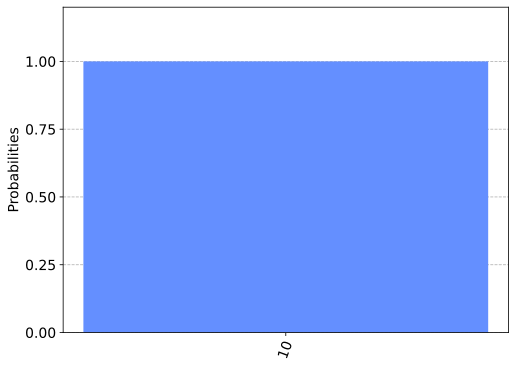

In [204]:
# test if correction can be detected on simulation
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(correction, backend=backend, shots=shots)
results = simulate.result()

plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False)

In [205]:
# test if correction can work on simulator

# measure all of the qubits
d = ClassicalRegister(9)
correction.barrier()

correction = correction + QuantumCircuit(d)

correction.measure(range(9), d)
#correction.draw()


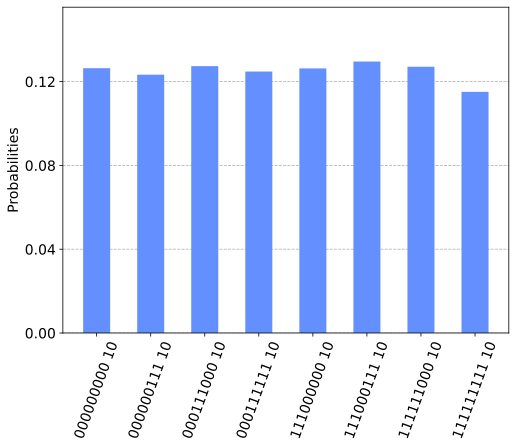

In [206]:

backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(correction, backend=backend, shots=shots)
results = simulate.result()

plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False)


In [0]:
# get counts for just the first register
sim_counts = dict()
for key in results.get_counts().keys():
  key1 = key.split(" ")
  sim_counts[key1[0]] = results.get_counts()[key]

In [208]:
# test fidelity with what we simulated before

fidelity(qc_results.get_counts(), sim_counts)

0.9997259964815775

## Testing phase flip
Note that correction CANNOT be run on hardware! Set correction = False in phaseflip_shor9

In [221]:
# encode state |0>
initial = [1, 0]
initial_circuit = initialize_shor9(initial)

# flip phase of qubit 2, 7
initial_circuit.z(2)
initial_circuit.z(7)

# circuit to detect for phase flip
correction = phaseflip_shor9(initial_circuit)
correction.draw()

┌─────────────────┐          ┌───┐                ░ ┌───┐     ┌───┐»
 q42_0: ┤ initialize(1,0) ├──■────■──┤ H ├──■────■────────░─┤ H ├──■──┤ H ├»
        └─────────────────┘  │    │  └───┘┌─┴─┐  │        ░ ├───┤  │  └───┘»
 q42_1: ─────────────────────┼────┼───────┤ X ├──┼────────░─┤ H ├──┼────■──»
                             │    │       └───┘┌─┴─┐┌───┐ ░ ├───┤  │    │  »
 q42_2: ─────────────────────┼────┼────────────┤ X ├┤ Z ├─░─┤ H ├──┼────┼──»
                           ┌─┴─┐  │  ┌───┐     └───┘└───┘ ░ ├───┤  │    │  »
 q42_3: ───────────────────┤ X ├──┼──┤ H ├──■────■────────░─┤ H ├──┼────┼──»
                           └───┘  │  └───┘┌─┴─┐  │        ░ ├───┤  │    │  »
 q42_4: ──────────────────────────┼───────┤ X ├──┼────────░─┤ H ├──┼────┼──»
                                  │       └───┘┌─┴─┐      ░ ├───┤  │    │  »
 q42_5: ──────────────────────────┼────────────┤ X ├──────░─┤ H ├──┼────┼──»
                                ┌─┴─┐┌───┐     └───┘      ░ ├───┤  │    │  »
 q42_6: ────────────────────────┤ X ├┤ H ├──■────■────────░─┤ H ├──┼────┼──»
                                └───┘└───┘┌─┴─┐  │  ┌───┐ ░ ├───┤  │    │  »
 q42_7: ──────────────────────────────────┤ X ├──┼──┤ Z ├─░─┤ H ├──┼────┼──»
                                          └───┘┌─┴─┐└───┘ ░ ├───┤  │    │  »
 q42_8: ───────────────────────────────────────┤ X ├──────░─┤ H ├──┼────┼──»
                                               └───┘      ░ └───┘┌─┴─┐┌─┴─┐»
 q42_9: ──────────────────────────────────────────────────░──────┤ X ├┤ X ├»
                                                          ░      └───┘└───┘»
q42_10: ──────────────────────────────────────────────────░────────────────»
                                                          ░                »
 c54_0: ═══════════════════════════════════════════════════════════════════»
                                                                           »
 c54_1: ═══════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                           »
« q42_0: ───────────────────────────────────────────────────────────────────»
«        ┌───┐                                                              »
« q42_1: ┤ H ├──────────────────────────────────────────────────────────────»
«        └───┘┌───┐                                                         »
« q42_2: ──■──┤ H ├─────────────────────────────────────────────────────────»
«          │  └───┘          ┌───┐                                    ┌───┐ »
« q42_3: ──┼────■─────────■──┤ H ├────────────────────────────────────┤ Z ├─»
«          │    │         │  └───┘     ┌───┐                          └─┬─┘ »
« q42_4: ──┼────┼────■────┼─────────■──┤ H ├────────────────────────────┼───»
«          │    │    │    │         │  └───┘┌───┐                       │   »
« q42_5: ──┼────┼────┼────┼────■────┼────■──┤ H ├───────────────────────┼───»
«          │    │    │    │    │    │    │  └───┘     ┌───┐             │   »
« q42_6: ──┼────┼────┼────┼────┼────┼────┼─────────■──┤ H ├─────────────┼───»
«          │    │    │    │    │    │    │         │  └───┘┌───┐        │   »
« q42_7: ──┼────┼────┼────┼────┼────┼────┼─────────┼────■──┤ H ├────────┼───»
«          │    │    │    │    │    │    │         │    │  └───┘┌───┐   │   »
« q42_8: ──┼────┼────┼────┼────┼────┼────┼─────────┼────┼────■──┤ H ├───┼───»
«        ┌─┴─┐┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │   ┌─┐   │    │    │  └───┘   │   »
« q42_9: ┤ X ├┤ X ├┤ X ├──┼──┤ X ├──┼────┼───┤M├───┼────┼────┼──────────┼───»
«        └───┘└───┘└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ └╥┘ ┌─┴─┐┌─┴─┐┌─┴─┐ ┌─┐    │   »
«q42_10: ───────────────┤ X ├─────┤ X ├┤ X ├──╫──┤ X ├┤ X ├┤ X ├─┤M├────┼───»
«                       └───┘     └───┘└───┘  ║  └───┘└───┘└───┘ └╥┘ ┌──┴──┐»
« c54_0: ═════════════════════════════════════╩═══════════════════╬══╡     ╞»
«                                                        

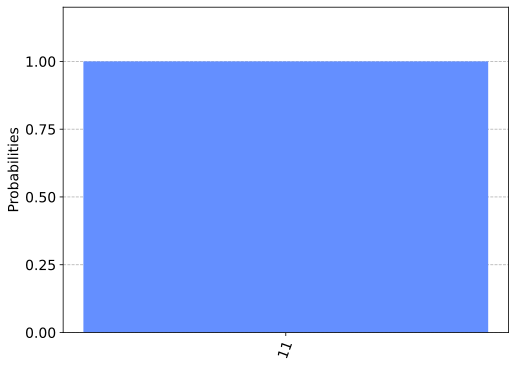

In [222]:
# test if correction can be detected on simulation
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(correction, backend=backend, shots=shots)
results = simulate.result()

plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False)

In [223]:
# test if correction can work on simulator

# measure all of the qubits
d = ClassicalRegister(9)
correction.barrier()

correction = correction + QuantumCircuit(d)

correction.measure(range(9), d)
#correction.draw()


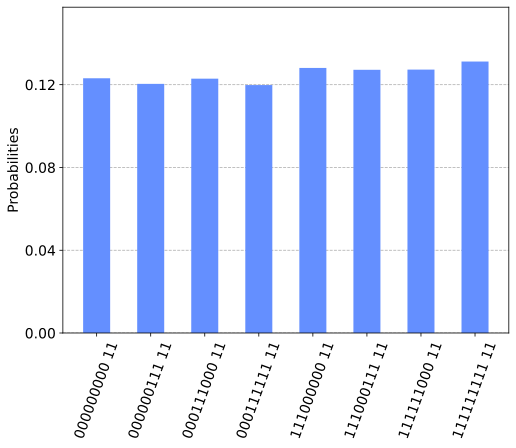

In [224]:

backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(correction, backend=backend, shots=shots)
results = simulate.result()

plot_histogram(results.get_counts(),figsize = (8,6),bar_labels = False)


In [0]:
# get counts for just the first register
sim_counts = dict()
for key in results.get_counts().keys():
  key1 = key.split(" ")
  sim_counts[key1[0]] = results.get_counts()[key]

In [226]:
# test fidelity with what we simulated before

fidelity(qc_results.get_counts(), sim_counts)

0.9996063492131864